In [160]:
import pandas as pd
import numpy as np
import wbgapi as wb
import yfinance as yf
import wbdata
from sklearn.linear_model import LinearRegression,LogisticRegression
import numpy as np
import scipy.stats as st
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import yfinance as yf
from statsmodels.formula.api import logit,ols
from statsmodels.api import Logit
import statsmodels.api as sm
import scipy.stats as st
import requests
import zipfile
import io
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import statsmodels.api as sm


# Overall Rules

- Refrain from saving datasets locally. You may experiment with your answers on a locally saved version of the datasets, but do not upload your local files with your homework as the datasets are very large. In your submitted answers datasets should be read from the original source URL.
- Document all of your steps by writing appropriate markdown cells in your notebook. Refrain from using code comments to explain what has been done.
- Avoid duplicating code. Do not copy and paste code from one cell to another. If copying and pasting is necessary, write a suitable function for the task at hand and call that function.
- Document your use of LLMs (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW2-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 25-point deduction for each infraction.

# HW2

## Q1

There are 22 countries surrounding the Mediterranean Sea: Spain, France, Monaco, Italy, Slovenia, Croatia, Bosnia and Herzegovina, Montenegro, Albania, Greece, Turkey, Syria, Lebanon, Israel, Palestine, Egypt, Libya, Tunisia, Algeria, and Morocco, with two island countries Malta and Cyprus.

1. Get the following data for every country in the list above from the World Bank Data server (using the `wbgapi` library)

- Adult female literacy (SE.ADT.LITR.FE.ZS)
- Adult female workforce participation rate (SL.TLF.ACTI.ZS)
- Child mortality rate (SP.DYN.IMRT.IN)
- Gini index (SI.POV.GINI)
- Life expectancy (SP.DYN.LE00.IN)
- GDP (NY.GDP.PCAP.CD)

2. Write a function that does linear regression for Log(mortality) against the other variables (except mortality).
3. Analyze the regression results for Spain, France, Turkey, Syria, and Israel.
4. Analyze the results for 2 other countries of your choice.

## Q1-Solutions

### 1) Ingesting the Data

I had already done a mini project on retrieving datas of Mediterreanen Countries before. So I had some help from that [project](https://github.com/etumkaya/381E_data_science/blob/main/HW1.ipynb) on ingesting the data. I wanted to write a function to fetch the data of the right indicators for each country.

In [46]:
def fetch_world_bank_data(country_codes):
    indicators = {
        "SE.ADT.LITR.FE.ZS": "Adult female literacy (% aged 15 and older)",
        "SL.TLF.ACTI.ZS": "Adult female workforce participation rate (% ages 15 and older)",
        "SP.DYN.IMRT.IN": "Child mortality rate (per 1,000 live births)",
        "SI.POV.GINI": "Gini index (World Bank estimate)",
        "SP.DYN.LE00.IN": "Life expectancy at birth (years)",
        "NY.GDP.PCAP.CD": "GDP per capita (current US$)"
    }

    country_data = {}

    for country_code in country_codes:
        try:
            data = wbdata.get_dataframe(indicators, country=country_code)
            country_data[country_code] = data
        except:
            print(f"Failed to fetch data for {country_code}")

    return country_data




I went on to find the right abbreviations for the surrounding countries. Later, I called my function, with inputs of the country codes, and stored the countries in a dictionary called "world_bank_data".

In [47]:
country_codes = ["FRA","ITA","SVN","HRV","BIH","MNE","ALB","GRC","TUR","SYR","LBN","ISR","PSE","EGY","LBY","TUN","DZA","MAR","MLT","CYP","MCO","ESP"]

world_bank_data = fetch_world_bank_data(country_codes)

turkey_data = world_bank_data["TUR"]
turkey_data

,Adult female literacy (% aged 15 and older),Adult female workforce participation rate (% ages 15 and older),"Child mortality rate (per 1,000 live births)",Gini index (World Bank estimate),Life expectancy at birth (years),GDP per capita (current US$)
date,,,,,,
2022,NaN,58.314,NaN,NaN,NaN,10674.504173
2021,NaN,56.321,7.7,NaN,76.032,9743.213131
2020,NaN,54.048,8.1,NaN,75.850,8638.739133
2019,94.424042,57.710,8.6,41.9,77.832,9215.440875
2018,NaN,57.714,9.2,41.9,77.563,9568.836190
...,...,...,...,...,...,...
1964,NaN,NaN,150.4,NaN,53.714,365.133869
1963,NaN,NaN,155.5,NaN,53.173,347.177091
1962,NaN,NaN,160.8,NaN,52.382,307.306286


It looks fine. However, there are lots of null values which I will be handling before building models.

### 2) Linear Regression Function

At this point, I tried to figure out the best method of validation for this task. I didn't want to use Hold Out Method because I wanted to form confidence intervals to be able to analyze my results better. Cross fold validation was one option but I was not planning on using "time" as a variable and didn't want to have the dependencies of time in my model evaluation. That is why I preffered Monte Carlo Cross Validation.

In [79]:
def linear_regression_monte_carlo(data, N=10):
    X = data.drop(columns=['Child mortality rate (per 1,000 live births)'])  
    y = np.log(data['Child mortality rate (per 1,000 live births)']) 
    
    r2_scores = []

    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        
        
        r2 = r2_score(y_test, y_predict)
        r2_scores.append(r2)

    mean_r2 = np.mean(r2_scores)
    interval = st.t.interval(0.95, df=N-1, loc=mean_r2, scale=st.sem(r2_scores))
    
    return mean_r2, interval
    

### 3) 

### Model Evaluation for Spain

First, I will take a look at my dataframe for Spain.

In [51]:
world_bank_data["ESP"].info()

<class 'wbdata.client.DataFrame'>
Index: 63 entries, 2022 to 1960
Data columns (total 6 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Adult female literacy (% aged 15 and older)                      17 non-null     float64
 1   Adult female workforce participation rate (% ages 15 and older)  32 non-null     float64
 2   Child mortality rate (per 1,000 live births)                     62 non-null     float64
 3   Gini index (World Bank estimate)                                 29 non-null     float64
 4   Life expectancy at birth (years)                                 62 non-null     float64
 5   GDP per capita (current US$)                                     63 non-null     float64
dtypes: float64(6)
memory usage: 3.4+ KB


Some features, namely female literacy and gini index have lots of missing values. Since there are lots of them I don't want to imputate them. I will have two approaches here, firstly I will delete the missing data and see my results. Secondly, I will remove the columns with null data majority and try the model like that. 

In [56]:
Spain_no_na=world_bank_data["ESP"].dropna()

Before I move on, I want to check the correlation table to see what is going on in a clearer way.

In [205]:
Spain_no_na.corr()

,Adult female literacy (% aged 15 and older),Adult female workforce participation rate (% ages 15 and older),"Child mortality rate (per 1,000 live births)",Gini index (World Bank estimate),Life expectancy at birth (years),GDP per capita (current US$)
Adult female literacy (% aged 15 and older),1.000000,0.580901,-0.851220,0.511491,0.776340,-0.092724
Adult female workforce participation rate (% ages 15 and older),0.580901,1.000000,-0.852879,0.907846,0.891739,0.271707
"Child mortality rate (per 1,000 live births)",-0.851220,-0.852879,1.000000,-0.832026,-0.952332,0.030913
Gini index (World Bank estimate),0.511491,0.907846,-0.832026,1.000000,0.868733,0.061226
Life expectancy at birth (years),0.776340,0.891739,-0.952332,0.868733,1.000000,-0.005456
GDP per capita (current US$),-0.092724,0.271707,0.030913,0.061226,-0.005456,1.000000


This tells a lot about the data, even though I have small number of data points. There is high correlation with female literacy ,and both life expectancy and also female workforce participation. I will try to choose what I will drop and keep carefully here. I dont want to lose child life expectancy because it has a really high correlation with child mortality, which is my target. On the other hand I find it useful to drop adult female literacy, female workforce participation and Gini index due to their high correlation with life expectancy. I will try my model like this.

In [208]:
Spain_new=Spain_no_na.drop(columns=["Adult female literacy (% aged 15 and older)", "Adult female workforce participation rate (% ages 15 and older)", "Gini index (World Bank estimate)"] )
Spain_new

,"Child mortality rate (per 1,000 live births)",Life expectancy at birth (years),GDP per capita (current US$)
date,,,
2020,2.6,82.331707,26984.296277
2018,2.7,83.431707,30379.721113
2016,2.7,83.329268,26537.159489
2015,2.8,82.831707,25754.361029
2014,2.8,83.229268,29513.651180
2013,2.9,83.078049,29077.182056
2012,2.9,82.426829,28322.946592
2011,3.0,82.475610,31677.900308
2010,3.2,81.626829,30532.480508


In [212]:
linear_regression_monte_carlo(Spain_new, N=1000)

(0.6279063638270245, (0.5598328995837077, 0.6959798280703412))

To have a comparasion, I want to try it on the dataset where I didnt drop the most correlated columns. I want to see how much it effects the r^2.

In [213]:
linear_regression_monte_carlo(Spain_no_na, N=1000)

(0.3323216518858384, (0.24554342032508336, 0.41909988344659344))

It almost decreased my r^2 mean to half. It shows how important it was to drop those.

### Model Evaluation for Turkey

In [218]:
Turkey_no_na=world_bank_data["TUR"].dropna()
Turkey_no_na.corr()

,Adult female literacy (% aged 15 and older),Adult female workforce participation rate (% ages 15 and older),"Child mortality rate (per 1,000 live births)",Gini index (World Bank estimate),Life expectancy at birth (years),GDP per capita (current US$)
Adult female literacy (% aged 15 and older),1.000000,0.947211,-0.976200,0.327856,0.947314,0.794527
Adult female workforce participation rate (% ages 15 and older),0.947211,1.000000,-0.950396,0.516710,0.966105,0.595473
"Child mortality rate (per 1,000 live births)",-0.976200,-0.950396,1.000000,-0.287875,-0.980433,-0.753991
Gini index (World Bank estimate),0.327856,0.516710,-0.287875,1.000000,0.377441,-0.084016
Life expectancy at birth (years),0.947314,0.966105,-0.980433,0.377441,1.000000,0.668591
GDP per capita (current US$),0.794527,0.595473,-0.753991,-0.084016,0.668591,1.000000


I will have the same approach. This time I need to drop "adult female literacy" and "adult female workforce".

In [222]:
Turkey_new=Turkey_no_na.drop(columns=["Adult female literacy (% aged 15 and older)", "Adult female workforce participation rate (% ages 15 and older)"] )
linear_regression_monte_carlo(Turkey_new, N=1000)

(0.913174917994578, (0.8973921954118251, 0.9289576405773308))

The model performed far better than I expected. 

### Model Evaluation for Israel

In [224]:
world_bank_data["ISR"].info()


<class 'wbdata.client.DataFrame'>
Index: 63 entries, 2022 to 1960
Data columns (total 6 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Adult female literacy (% aged 15 and older)                      1 non-null      float64
 1   Adult female workforce participation rate (% ages 15 and older)  32 non-null     float64
 2   Child mortality rate (per 1,000 live births)                     62 non-null     float64
 3   Gini index (World Bank estimate)                                 22 non-null     float64
 4   Life expectancy at birth (years)                                 58 non-null     float64
 5   GDP per capita (current US$)                                     38 non-null     float64
dtypes: float64(6)
memory usage: 3.4+ KB


This dataset only has 1 non-null values for female literacy. Thus, I will drop that column and perform the other tasks.

In [225]:
world_bank_data["ISR"].drop(columns=["Adult female literacy (% aged 15 and older)"],inplace=True)

In [228]:
Israel_new=world_bank_data["ISR"].dropna()

In [229]:
Israel_new.corr()

,Adult female workforce participation rate (% ages 15 and older),"Child mortality rate (per 1,000 live births)",Gini index (World Bank estimate),Life expectancy at birth (years),GDP per capita (current US$)
Adult female workforce participation rate (% ages 15 and older),1.000000,-0.890512,-0.256966,0.899628,0.941327
"Child mortality rate (per 1,000 live births)",-0.890512,1.000000,-0.070339,-0.990759,-0.905544
Gini index (World Bank estimate),-0.256966,-0.070339,1.000000,0.000185,-0.271560
Life expectancy at birth (years),0.899628,-0.990759,0.000185,1.000000,0.929013
GDP per capita (current US$),0.941327,-0.905544,-0.271560,0.929013,1.000000


This is surprising to see. Life expectancy and child mortality is 0.99 positively correlated.  I will drop gdp and female workforce this time.

In [230]:
Israel_new1=Israel_new.drop(columns=["Adult female workforce participation rate (% ages 15 and older)", "GDP per capita (current US$)"] )

In [231]:
linear_regression_monte_carlo(Israel_new, N=1000)

(0.9739051233031243, (0.9721862616247915, 0.9756239849814571))

### Model Evaluation for France

In [232]:
world_bank_data["FRA"].info()


<class 'wbdata.client.DataFrame'>
Index: 63 entries, 2022 to 1960
Data columns (total 6 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Adult female literacy (% aged 15 and older)                      0 non-null      object 
 1   Adult female workforce participation rate (% ages 15 and older)  32 non-null     float64
 2   Child mortality rate (per 1,000 live births)                     62 non-null     float64
 3   Gini index (World Bank estimate)                                 30 non-null     float64
 4   Life expectancy at birth (years)                                 62 non-null     float64
 5   GDP per capita (current US$)                                     63 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.4+ KB


Once again, I will drop female literacy because I dont have any data. Then I will perform the same operations calling the function I designed.

In [234]:
France_no_na=world_bank_data["FRA"].drop(columns=["Adult female literacy (% aged 15 and older)"])
France_no_na.corr()

,Adult female workforce participation rate (% ages 15 and older),"Child mortality rate (per 1,000 live births)",Gini index (World Bank estimate),Life expectancy at birth (years),GDP per capita (current US$)
Adult female workforce participation rate (% ages 15 and older),1.000000,-0.787194,0.033874,0.936699,0.789432
"Child mortality rate (per 1,000 live births)",-0.787194,1.000000,0.744426,-0.936331,-0.883921
Gini index (World Bank estimate),0.033874,0.744426,1.000000,-0.597313,-0.523738
Life expectancy at birth (years),0.936699,-0.936331,-0.597313,1.000000,0.979236
GDP per capita (current US$),0.789432,-0.883921,-0.523738,0.979236,1.000000


In [242]:
France_new1

,"Child mortality rate (per 1,000 live births)",Life expectancy at birth (years)
date,,
2020,3.4,82.175610
2019,3.4,82.826829
2018,3.4,82.675610
2017,3.3,82.575610
2016,3.2,82.573171
2015,3.2,82.321951
2014,3.1,82.719512
2013,3.1,82.219512
2012,3.1,81.968293


In [241]:
France_new=France_no_na.dropna()
France_new1=France_new.drop(columns=["Adult female workforce participation rate (% ages 15 and older)","GDP per capita (current US$)","Gini index (World Bank estimate)"])

In [244]:
linear_regression_monte_carlo(France_new1, N=1000)

(0.2886000338591023, (0.2075539068959415, 0.36964616082226315))

### 4)
 
### Models for Albania and Greece

### Albania

In [247]:
Albania=world_bank_data["ALB"]
Albania.isna().sum()

Adult female literacy (% aged 15 and older)                        58
Adult female workforce participation rate (% ages 15 and older)    31
Child mortality rate (per 1,000 live births)                       19
Gini index (World Bank estimate)                                   51
Life expectancy at birth (years)                                    1
GDP per capita (current US$)                                       24
dtype: int64

In [248]:
Albania_new=Albania.drop(columns=["Adult female literacy (% aged 15 and older)","Gini index (World Bank estimate)"])
Albania_new1=Albania_new.dropna()

In [255]:
Albania_new1.corr()

,Adult female workforce participation rate (% ages 15 and older),"Child mortality rate (per 1,000 live births)",Life expectancy at birth (years),GDP per capita (current US$)
Adult female workforce participation rate (% ages 15 and older),1.000000,0.414611,-0.426228,-0.327359
"Child mortality rate (per 1,000 live births)",0.414611,1.000000,-0.954404,-0.961266
Life expectancy at birth (years),-0.426228,-0.954404,1.000000,0.886470
GDP per capita (current US$),-0.327359,-0.961266,0.886470,1.000000


In [249]:
linear_regression_monte_carlo(Albania_new1, N=1000)

(0.9245394366781928, (0.9207991462530593, 0.9282797271033264))

### Greece

In [250]:
Greece=world_bank_data["GRC"]
Greece.isna().sum()

Adult female literacy (% aged 15 and older)                        59
Adult female workforce participation rate (% ages 15 and older)    31
Child mortality rate (per 1,000 live births)                        1
Gini index (World Bank estimate)                                   43
Life expectancy at birth (years)                                    1
GDP per capita (current US$)                                        0
dtype: int64

In [280]:
Greece_new=Greece.drop(columns=["Adult female literacy (% aged 15 and older)"])
Greece_new1=Greece_new.dropna()

In [273]:
Greece_new1.corr()

,Adult female workforce participation rate (% ages 15 and older),"Child mortality rate (per 1,000 live births)",Gini index (World Bank estimate),Life expectancy at birth (years),GDP per capita (current US$)
Adult female workforce participation rate (% ages 15 and older),1.000000,-0.944344,-0.195992,0.835477,0.482236
"Child mortality rate (per 1,000 live births)",-0.944344,1.000000,0.341382,-0.742080,-0.629064
Gini index (World Bank estimate),-0.195992,0.341382,1.000000,-0.072331,-0.242747
Life expectancy at birth (years),0.835477,-0.742080,-0.072331,1.000000,0.149752
GDP per capita (current US$),0.482236,-0.629064,-0.242747,0.149752,1.000000


In [281]:
Greece_new1=Greece_new1.drop(columns=["Life expectancy at birth (years)","GDP per capita (current US$)","Gini index (World Bank estimate)"])

In [282]:
Greece_new1

,Adult female workforce participation rate (% ages 15 and older),"Child mortality rate (per 1,000 live births)"
date,,
2020,66.008,3.4
2019,67.039,3.5
2018,66.903,3.7
2017,67.078,3.8
2016,67.116,3.9
2015,67.003,3.8
2014,66.828,3.8
2013,66.943,3.6
2012,66.895,3.5


In [285]:
linear_regression_monte_carlo(Greece_new1, N=1000)

(-0.16540172799785305, (-0.32812889141687873, -0.002674564578827393))

This was an unusual case for me. R^2 shouldnt be negative. I will try to comment on why this happened.

## Q2

Get the following commodity price data from yahoo finance using the `yfinance` library:

- Silver (SI=F)
- Copper (HG=F)
- Platinum (PL=F)
- Gold (GC=F)
- Palladium (PA=F)

1. Write a linear regression model that relates the gold futures in terms of the other precious metals.
2. Analyze the regression results.
3. Does the model improve if we add interaction terms? Explain.
4. Now, do the same for each futures in the list above.

## Q2-Solutions

### Ingesting the Data

In [5]:
commodity_tickers = ['SI=F', 'HG=F', 'PL=F','GC=F','PA=F']


commodity_data = yf.download(commodity_tickers)


commodity_dataset=commodity_data["Close"].dropna()
commodity_dataset.rename(columns={'SI=F':"Silver","HG=F":"Copper","PL=F":"Platinum","GC=F":"Gold","PA=F":"Palladium"},inplace=True)
commodity_dataset

[*********************100%%**********************]  5 of 5 completed


,Gold,Copper,Palladium,Platinum,Silver
Date,,,,,
2000-08-30,273.899994,0.8850,711.049988,591.400024,4.930000
2000-08-31,278.299988,0.8850,716.750000,586.700012,5.003000
2000-09-01,277.000000,0.8890,724.700012,595.299988,5.004000
2000-09-05,275.799988,0.9060,720.650024,601.299988,4.998000
2000-09-06,274.200012,0.9015,738.000000,611.099976,4.983000
...,...,...,...,...,...
2024-03-18,2160.699951,4.1145,1035.599976,918.500000,25.091000
2024-03-19,2156.300049,4.0585,993.900024,898.900024,24.964001
2024-03-20,2157.899902,4.0385,994.700012,897.099976,24.933001


In [299]:
commodity_dataset.corr()

,Gold,Copper,Palladium,Platinum,Silver
Gold,1.000000,0.875668,0.693268,0.475030,0.861032
Copper,0.875668,1.000000,0.546985,0.692800,0.877438
Palladium,0.693268,0.546985,1.000000,-0.037672,0.421329
Platinum,0.475030,0.692800,-0.037672,1.000000,0.767286
Silver,0.861032,0.877438,0.421329,0.767286,1.000000


### 1-2) Linear Regression for Exploratory Modeling

For this task, I thought it would be more reasonable to perform exploratory modeling instead of a predictive one. I will use statsmodel library since it gives me more insight on the relations of the features.

In [6]:
model = ols('Gold ~ Silver + Palladium + Platinum + Palladium ', data=commodity_dataset).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                 1.216e+04
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:46:11   Log-Likelihood:                -32942.
No. Observations:                4948   AIC:                         6.589e+04
Df Residuals:                    4944   BIC:                         6.592e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    273.1969     11.084     24.648      0.000     251.467     294.926
Silver        53.1167      0.677     78.463      0.000      51.790      54.444
Palladium      0.2768      0.006     47.969      0.000       0.265       0.288
Platinum      -0.2484      0.015    -16.432      0.000      -0.278      -0.219
==============================================================================
Omnibus:                      479.522   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1032.526
Skew:                          -0.611   Prob(JB):                    6.16e-225
Kurtosis:                       4.875   Cond. No.                     6.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

"0.881" R^2 tells me that the model does somewhat well in explaining the variance in our target. The coefficients here don't mean much in terms of their magnitude. However they at least tell in which way they are correlated with the gold values. Platinum is likely to be negatively related with gold. Others seem to be positively correlated.  


To see which feature is the most related with the target I will perform ANOVA tests. 

In [7]:
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Silver,1.0,1.091633e+09,1.091633e+09,30721.350775,0.000000e+00
Palladium,1.0,1.955332e+08,1.955332e+08,5502.803473,0.000000e+00
Platinum,1.0,9.594820e+06,9.594820e+06,270.022762,4.042642e-59
Residual,4944.0,1.756770e+08,3.553337e+04,NaN,NaN


This tells me that the Silver has the most obvious and strong relation to gold price. Platinum is the least one but the p value still tells us that it is significant.

I will check the correlation table and see if I can improve the R^2.

In [8]:
commodity_dataset.corr()

,Gold,Copper,Palladium,Platinum,Silver
Gold,1.000000,0.875667,0.693265,0.475028,0.861033
Copper,0.875667,1.000000,0.546985,0.692802,0.877439
Palladium,0.693265,0.546985,1.000000,-0.037672,0.421327
Platinum,0.475028,0.692802,-0.037672,1.000000,0.767284
Silver,0.861033,0.877439,0.421327,0.767284,1.000000


Silver and Copper, and Silver and Platinum are strongly correlated. I will drop Silver and see how my results change.

In [26]:

model = ols('Gold ~  Palladium + Platinum + Copper ', data=commodity_dataset).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     8184.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:06:35   Log-Likelihood:                -33783.
No. Observations:                4948   AIC:                         6.757e+04
Df Residuals:                    4944   BIC:                         6.760e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.4103     11.905      3.226      0.001      15.071      61.750
Palladium      0.2477      0.008     30.851      0.000       0.232       0.263
Platinum      -0.0241      0.017     -1.396      0.163      -0.058       0.010
Copper       349.1871      6.421     54.382      0.000     336.599     361.775
==============================================================================
Omnibus:                      108.761   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.051
Skew:                          -0.299   Prob(JB):                     2.12e-29
Kurtosis:                       3.531   Cond. No.                     5.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

My R^2 is down. This indicates that it wasnt the solution I wanted.

### 3) Interaction Terms

This time, instead of removing silver from the model, I will transform the most correlated ones to interaction terms and try to get a better looking R^2.

In [12]:
commodity_dataset.corr()

,Gold,Copper,Palladium,Platinum,Silver
Gold,1.000000,0.875667,0.693265,0.475028,0.861033
Copper,0.875667,1.000000,0.546985,0.692802,0.877439
Palladium,0.693265,0.546985,1.000000,-0.037672,0.421327
Platinum,0.475028,0.692802,-0.037672,1.000000,0.767284
Silver,0.861033,0.877439,0.421327,0.767284,1.000000


In [18]:
model = ols('Gold ~ Silver*Copper + Platinum + Palladium  ', data=commodity_dataset).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 2.207e+04
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:01:08   Log-Likelihood:                -30409.
No. Observations:                4948   AIC:                         6.083e+04
Df Residuals:                    4942   BIC:                         6.087e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -70.7735      8.328     -8.498      0.000     -87.100     -54.447
Silver           96.0013      0.845    113.633      0.000      94.345      97.658
Copper          328.3566      3.984     82.415      0.000     320.546     336.167
Silver:Copper   -14.5062      0.192    -75.524      0.000     -14.883     -14.130
Platinum         -0.5732      0.010    -56.453      0.000      -0.593      -0.553
Palladium         0.1260      0.004     29.849      0.000       0.118       0.134
==============================================================================
Omnibus:                      243.182   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              855.474
Skew:                          -0.095   Prob(JB):                    1.72e-186
Kurtosis:                       5.028   Cond. No.                     7.81e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Turning two highly correlated features to one interaction term positively effected my R^2. I will see if I can take it to a better level.

In [19]:
model = ols('Gold ~ Silver*Copper*Platinum + Palladium  ', data=commodity_dataset).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 1.837e+04
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:03:21   Log-Likelihood:                -29726.
No. Observations:                4948   AIC:                         5.947e+04
Df Residuals:                    4939   BIC:                         5.953e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.3786     22.351      0.017      0.986     -43.438      44.196
Silver                    98.8453      3.027     32.656      0.000      92.911     104.779
Copper                   -36.6736     12.233     -2.998      0.003     -60.657     -12.691
Silver:Copper              2.4079      0.631      3.819      0.000       1.172       3.644
Platinum                  -0.3397      0.037     -9.246      0.000      -0.412      -0.268
Silver:Platinum           -0.0105      0.003     -3.786      0.000      -0.016      -0.005
Copper:Platinum            0.1628      0.011     14.609      0.000       0.141       0.185
Silver:Copper:Platinum    -0.0083      0.001    -15.156      0.000      -0.009      -0.007
Palladium                  0.0849      0.004     21.419      0.000       0.077       0.093
==============================================================================
Omnibus:                      213.521   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              697.872
Skew:                           0.060   Prob(JB):                    2.88e-152
Kurtosis:                       4.836   Cond. No.                     1.62e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
model = ols('Gold ~ Silver*Palladium*Copper*Platinum  ', data=commodity_dataset).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.843e+04
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:08:00   Log-Likelihood:                -28198.
No. Observations:                4948   AIC:                         5.643e+04
Df Residuals:                    4932   BIC:                         5.653e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          478.2798     40.790     11.726      0.000     398.314     558.246
Silver                              20.9851      5.656      3.711      0.000       9.898      32.073
Palladium                           -1.0061      0.083    -12.120      0.000      -1.169      -0.843
Silver:Palladium                     0.1020      0.006     15.776      0.000       0.089       0.115
Copper                            -906.5688     28.539    -31.766      0.000    -962.518    -850.619
Silver:Copper                       59.7052      1.521     39.253      0.000      56.723      62.687
Palladium:Copper                     0.8918      0.036     24.679      0.000       0.821       0.963
Silver:Palladium:Copper             -0.0556      0.002    -35.963      0.000      -0.059      -0.053
Platinum                             0.0490      0.057      0.856      0.392      -0.063       0.161
Silver:Platinum                      0.0201      0.005      3.783      0.000       0.010       0.030
Palladium:Platinum                   0.0007      0.000      5.257      0.000       0.000       0.001
Silver:Palladium:Platinum        -8.377e-05   7.44e-06    -11.259      0.000   -9.84e-05   -6.92e-05
Copper:Platinum                      0.5164      0.025     20.760      0.000       0.468       0.565
Silver:Copper:Platinum              -0.0388      0.001    -30.672      0.000      -0.041      -0.036
Palladium:Copper:Platinum           -0.0005   4.22e-05    -12.883      0.000      -0.001      -0.000
Silver:Palladium:Copper:Platinum  3.948e-05   1.66e-06     23.791      0.000    3.62e-05    4.27e-05
==============================================================================
Omnibus:                      409.059   Durbin-Watson:                   0.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1290.209
Skew:                           0.414   Prob(JB):                    6.83e-281
Kurtosis:                       5.360   Cond. No.                     4.62e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is the highest one I could find. It surprised me that when I multiply all the features I get the highest r^2. Maybe it is due to the fact that all these commodities were correlated with each other.

### Trying Regularization

In [61]:
model = ols('Gold ~ Palladium + Copper +Platinum + Gold ', data=commodity_dataset).fit_regularized(method='elastic_net')

N = commodity_dataset.shape[1]
RSS = np.linalg.norm(commodity_dataset['Gold']-model.fittedvalues)
RSE = np.linalg.norm(commodity_dataset['Gold']-commodity_dataset['Gold'].mean())
R2 = 1 - RSS/RSE
R2

0.8683129371619833

It didn't seem to have a positive impact for this model. I used the code from our [lecture](https://github.com/kaygun/2024-Spring-388E/blob/main/lectures/lecture-05.ipynb) here.

### 4) Models for Other Commodities

For this part, based on the correlation table and also newly added interaction terms I tried to find the highest R^2 for each.

### Silver

In [48]:
model = ols('Silver ~ Palladium * Copper +Platinum * Gold ', data=commodity_dataset).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Silver   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 2.018e+04
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:19:53   Log-Likelihood:                -9696.9
No. Observations:                4948   AIC:                         1.941e+04
Df Residuals:                    4941   BIC:                         1.945e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.1514      0.204     39.972      0.000       7.752       8.551
Palladium            0.0004      0.000      2.669      0.008       0.000       0.001
Copper               1.7723      0.091     19.531      0.000       1.594       1.950
Palladium:Copper    -0.0003   4.46e-05     -7.162      0.000      -0.000      -0.000
Platinum            -0.0099      0.000    -31.745      0.000      -0.011      -0.009
Gold                -0.0044      0.000    -18.732      0.000      -0.005      -0.004
Platinum:Gold     1.532e-05   1.94e-07     79.097      0.000    1.49e-05    1.57e-05
==============================================================================
Omnibus:                     2049.746   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21030.560
Skew:                           1.693   Prob(JB):                         0.00
Kurtosis:                      12.516   Cond. No.                     1.32e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Palladium

In [43]:
model = ols('Palladium ~ Silver* Copper *Gold *Platinum ', data=commodity_dataset).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Palladium   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     1202.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:18:35   Log-Likelihood:                -35287.
No. Observations:                4948   AIC:                         7.061e+04
Df Residuals:                    4932   BIC:                         7.071e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    3763.3614    209.168     17.992      0.000    3353.300    4173.423
Silver                      -1158.3675     63.606    -18.211      0.000   -1283.064   -1033.671
Copper                      -1016.9587    164.313     -6.189      0.000   -1339.086    -694.831
Silver:Copper                 386.6314     16.159     23.927      0.000     354.953     418.309
Gold                            1.4128      0.411      3.435      0.001       0.607       2.219
Silver:Gold                     0.7583      0.039     19.311      0.000       0.681       0.835
Copper:Gold                    -0.7716      0.162     -4.775      0.000      -1.088      -0.455
Silver:Copper:Gold             -0.2148      0.010    -20.572      0.000      -0.235      -0.194
Platinum                       -1.2246      0.271     -4.517      0.000      -1.756      -0.693
Silver:Platinum                 0.7368      0.069     10.730      0.000       0.602       0.871
Copper:Platinum                 0.1286      0.114      1.126      0.260      -0.095       0.353
Silver:Copper:Platinum         -0.2441      0.016    -15.542      0.000      -0.275      -0.213
Gold:Platinum                  -0.0014      0.000     -3.245      0.001      -0.002      -0.001
Silver:Gold:Platinum           -0.0006   3.74e-05    -14.850      0.000      -0.001      -0.000
Copper:Gold:Platinum            0.0010      0.000      7.290      0.000       0.001       0.001
Silver:Copper:Gold:Platinum     0.0001   8.95e-06     16.707      0.000       0.000       0.000
==============================================================================
Omnibus:                      225.339   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.569
Skew:                           0.404   Prob(JB):                     1.24e-76
Kurtosis:                       4.021   Cond. No.                     8.02e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.02e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Platinum

In [58]:
model = ols('Platinum ~ Silver* Gold * Copper *Palladium ', data=commodity_dataset).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Platinum   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     3301.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:21:21   Log-Likelihood:                -30100.
No. Observations:                4948   AIC:                         6.023e+04
Df Residuals:                    4932   BIC:                         6.034e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      566.3642     34.087     16.615      0.000     499.539     633.189
Silver                         238.3740     10.008     23.818      0.000     218.754     257.994
Gold                            -3.0134      0.085    -35.331      0.000      -3.181      -2.846
Silver:Gold                     -0.0086      0.005     -1.718      0.086      -0.018       0.001
Copper                        -182.3372     24.219     -7.529      0.000    -229.816    -134.858
Silver:Copper                  -23.7143      2.268    -10.457      0.000     -28.160     -19.269
Gold:Copper                      0.9096      0.030     29.976      0.000       0.850       0.969
Silver:Gold:Copper              -0.0158      0.001    -13.462      0.000      -0.018      -0.013
Palladium                       -0.3048      0.053     -5.792      0.000      -0.408      -0.202
Silver:Palladium                -0.1411      0.012    -11.896      0.000      -0.164      -0.118
Gold:Palladium                   0.0019    7.1e-05     26.499      0.000       0.002       0.002
Silver:Gold:Palladium         9.541e-06   5.41e-06      1.764      0.078   -1.06e-06    2.01e-05
Copper:Palladium                 0.2328      0.048      4.884      0.000       0.139       0.326
Silver:Copper:Palladium          0.0213      0.003      7.887      0.000       0.016       0.027
Gold:Copper:Palladium           -0.0006    3.5e-05    -17.709      0.000      -0.001      -0.001
Silver:Gold:Copper:Palladium  7.232e-06   1.32e-06      5.496      0.000    4.65e-06    9.81e-06
==============================================================================
Omnibus:                       99.073   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.963
Skew:                           0.186   Prob(JB):                     1.12e-35
Kurtosis:                       3.801   Cond. No.                     4.14e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Q3

Use the *Acoustic Extinguisher Fire Dataset* from Murat Köklü's [data server](https://www.muratkoklu.com/datasets/).

1. Explore the dataset, and project it to 2D space using PCA and LDA. Color the data points using the `STATUS` column.
2. Construct an SVM model to model the `STATUS` column and measure its quality using Accuracy, Precision, Recall, and F-1.
3. Construct a Logistic Regression model to model the `STATUS` column and measure its quality using Accuracy, Precision, Recall, and F-1.
4. Using the LR model, determine which variables affect the most the `STATUS` column.

## Q3 - Solutions

## 1) 

### Ingesting the Data


Since I didn't want to save the dataset locally, I wrote the code below. It sends a request to the zip file, opens it and then extracts the excel file. Finds the requested sheet and then turns the data into a Pandas df.

In [64]:
url = "https://www.muratkoklu.com/datasets/vtdhnd07.php"


response = requests.get(url)


if response.status_code == 200:
    
    with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
       
        excel_file = [file for file in zip_ref.namelist() if file.endswith('.xlsx')][0]
        
        
        Fire_Dataset  = pd.read_excel(zip_ref.open(excel_file), sheet_name="A_E_Fire_Dataset")
    
   
    
else:
    print("Failed to download the file.")
    
    

In [67]:
Fire_Dataset

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


In [66]:
Fire_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


It seems the datatypes are correct and I won't be needing to handle null values. Fuel feature and Status feature are categorical and I will be transforming it depending on the task.

In [68]:
Fire_Dataset.describe()

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,3.411765,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,150.000000,104.000000,11.200000,47.000000,1.000000
max,7.000000,190.000000,113.000000,17.000000,75.000000,1.000000


In [82]:
Fire_Dataset["STATUS"].groupby(Fire_Dataset["STATUS"]).count()

STATUS
0    8759
1    8683
Name: STATUS, dtype: int64

### PCA

In order to perform PCA, I will need to scale my data first. For that, I splitted the data to numerical and categorical ones. Afterwards, I will handle the categorical variables performing one hot encoding.

In [106]:
Fire_Dataset_num=Fire_Dataset[["SIZE","DISTANCE","DESIBEL","AIRFLOW","FREQUENCY"]]
Scaler=StandardScaler()
Scaler.fit(Fire_Dataset_num)
Scaled_numerical=Scaler.transform(Fire_Dataset_num)
Fire_Dataset_cat=Fire_Dataset[["FUEL"]]
one_hot_encoded1 = pd.get_dummies(Fire_Dataset_cat['FUEL'], prefix='Fuel')
df_encoded = pd.concat([pd.DataFrame(Scaled_numerical), one_hot_encoded1,Fire_Dataset["STATUS"] ], axis=1)
df_encoded.columns = df_encoded.columns.astype(str)

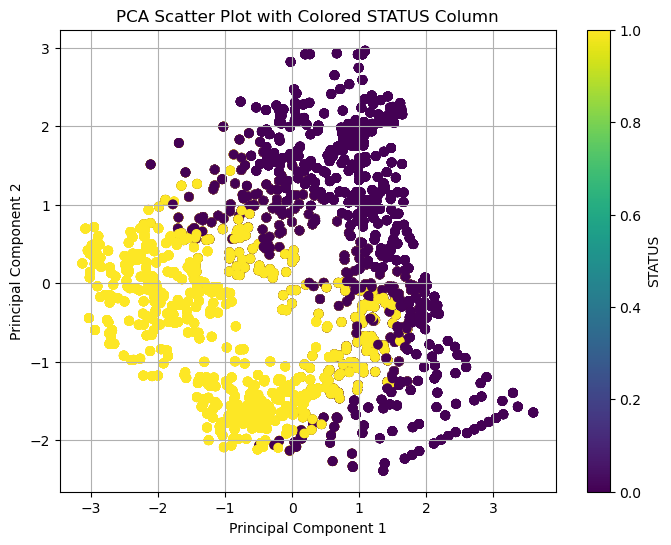

In [100]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_encoded.drop("STATUS", axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_encoded["STATUS"], cmap='viridis')
plt.title('PCA Scatter Plot with Colored STATUS Column')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='STATUS')
plt.grid(True)
plt.show()

### LDA

I went on to perform LDA this time. Since "STATUS" column have only two categories I plotted the LDA in one dimension.

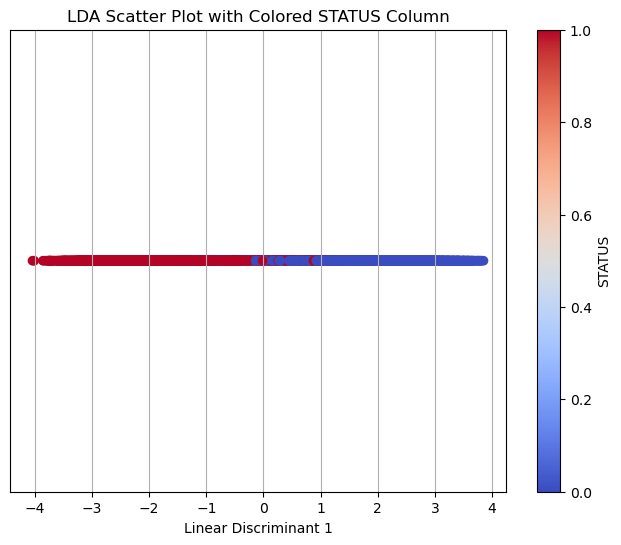

In [111]:
lda = LDA(n_components=1)


lda_result = lda.fit_transform(df_encoded.drop("STATUS", axis=1), df_encoded["STATUS"])


plt.figure(figsize=(8, 6))
plt.scatter(lda_result, [0] * len(lda_result), c=df_encoded["STATUS"], cmap='coolwarm', marker='o')
plt.title('LDA Scatter Plot with Colored STATUS Column')
plt.xlabel('Linear Discriminant 1')
plt.yticks([])
plt.colorbar(label='STATUS')
plt.grid(True)
plt.show()

### 2) Modeling with SVM

There are some things I need to do first. Since SVM's work better with scaled data, due to the fact that they rely on distances between data points, I will scale the dataset. Another important point is to vectorize the categorical features. "Fuel" will be categorized for sure. However, I didn't find it neccessary to categorize "SIZE". It felt as a natural label encoding which can be used as continous variable although it doesn't have many unique values.



In [118]:
Fire_Dataset

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


In [133]:
one_hot= pd.get_dummies(Fire_Dataset['FUEL'], prefix='Fuel')
scaledfire=Scaler.fit_transform(Fire_Dataset.drop(['FUEL',"STATUS"],axis=1))
y=Fire_Dataset["STATUS"]
X=pd.concat([pd.DataFrame(scaledfire), one_hot ], axis=1)
X.columns=X.columns.astype(str)
pd.DataFrame(scaledfire)

,0,1,2,3,4
0,-1.377422,-1.643168,-0.046442,-1.472885,2.072201
1,-1.377422,-1.643168,-0.046442,-1.472885,1.928925
2,-1.377422,-1.643168,-0.046442,-0.923903,1.833407
3,-1.377422,-1.643168,-0.046442,-0.797214,1.737890
4,-1.377422,-1.643168,1.545942,-0.522723,1.690131
...,...,...,...,...,...
17437,2.049335,1.643168,-1.271352,-1.008361,-1.270915
17438,2.049335,1.643168,-1.516334,-1.050591,-1.318674
17439,2.049335,1.643168,-2.006298,-1.156165,-1.366432
17440,2.049335,1.643168,-2.496262,-1.388426,-1.414191


I will define a function just like we did in the class. It will help me use different models without needing to code the same things.

In [136]:
def getCM(X,y,model,test_size,train_size):                
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,train_size=train_size)
    model.fit(X_train, y_train)                           
    y_predict = model.predict(X_test)                      
    
    return classification_report(y_test,y_predict)

In [158]:
print(getCM(X,y,SVC(),0.25,0.75))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2163
           1       0.95      0.94      0.95      2198

    accuracy                           0.95      4361
   macro avg       0.95      0.95      0.95      4361
weighted avg       0.95      0.95      0.95      4361



### 3) Modeling using Logistic Regression 

Now I will call the function to perform Logistic regression.

In [159]:
print(getCM(X,y,LogisticRegression(),0.25,0.75))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2184
           1       0.91      0.89      0.90      2177

    accuracy                           0.90      4361
   macro avg       0.90      0.90      0.90      4361
weighted avg       0.90      0.90      0.90      4361



### 4) Effects of Features

To asses the importance of the features, I will use "statsmodels.api" importing "Logit". 


In [168]:
Fire_Dataset

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


In [192]:
y = Fire_Dataset["STATUS"]


X = Fire_Dataset[["SIZE", "DISTANCE", "DESIBEL", "AIRFLOW", "FREQUENCY"]]


one_hot = pd.get_dummies(Fire_Dataset['FUEL'], drop_first=True)


X = pd.concat([X, one_hot], axis=1)
X = X.astype(int)


logit_model = sm.Logit(endog=y, exog=X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.231566
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 STATUS   No. Observations:                17442
Model:                          Logit   Df Residuals:                    17434
Method:                           MLE   Df Model:                            7
Date:                Mon, 25 Mar 2024   Pseudo R-squ.:                  0.6659
Time:                        18:38:46   Log-Likelihood:                -4039.0
converged:                       True   LL-Null:                       -12090.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SIZE          -0.9006      0.026    -34.651      0.000      -0.952      -0.850
DISTANCE      -0.0259      0.

Since independent data matrix was not scaled, coefficients here are not good indicators how important the features are. Instead, we can check the z-scores. "Airflow" has the most importance and the binary vector "thinner" had the lowest.

## Q4

Use the hyperspectral image data (ROSIS sensor data over Pavia Italy) we used for Question 2 from HW1 for this question.

1. Load both the image data and the ground truth data. Reshape the image and name is as `vectors` and the ground truth data as `labels`. 
2. Remove all data points whose label is 0.
3. Write a function that construct a multi-label logistic regression model relating `vectors` to `labels`, and analyzes the accuracy using a correct statistical methodology. Analyze the accuracy results.
4. Now, run a model once over a single training and test set. Report the accuracy, precision, recall, and F1 per label basis. 
5. Repeat (3) and (4) for a multi-label SVM model.
6. Construct confusion matrices over a single run for both LR and SVM, and compare. Present your conclusions.